In [4]:
import joblib

In [1]:
import pandas as pd
import pickle
from sklearn.externals import joblib
from pandas.api.types import is_string_dtype,is_numeric_dtype,is_int64_dtype
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score
from sklearn.externals import joblib
from matplotlib import pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import category_encoders as ce

%matplotlib inline

In [2]:
%pwd

'C:\\Users\\Soumya\\Documents\\NEU\\INFO6105\\airbnb-recruiting-new-user-bookings'

In [3]:
my_path = "C:\\Users\\Soumya\\Documents\\NEU\\INFO6105\\airbnb-recruiting-new-user-bookings"

In [4]:
mydf_train = pd.read_csv(f'{my_path}/train_users_2.csv',parse_dates = ["date_account_created"])
print(mydf_train.shape)
mydf_train.head(3)

(213451, 16)


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US


In [5]:
mydf_train.rename(columns={'country_destination': 'country'}, inplace=True) # rename country column

In [6]:
mydf_train.head(2)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF


In [7]:
country_lookup = dict(zip(mydf_train['country'].astype('category').cat.codes + 1,
                          mydf_train['country']))

In [8]:
country_lookup

{8: 'NDF',
 11: 'US',
 12: 'other',
 5: 'FR',
 2: 'CA',
 6: 'GB',
 4: 'ES',
 7: 'IT',
 10: 'PT',
 9: 'NL',
 3: 'DE',
 1: 'AU'}

#### Plot to view percentage of bookings for each destination

Text(0, 0.5, 'Percentage of booking')

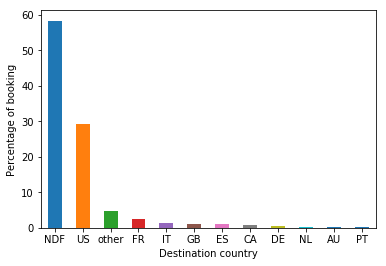

In [9]:
sns.set_style()
destn_countries = mydf_train.country.value_counts(dropna = False) / mydf_train.shape[0] * 100
destn_countries.plot('bar', rot = 0)
plt.xlabel('Destination country')
plt.ylabel('Percentage of booking')

#### Plot to view the percentage of missing values for each feature

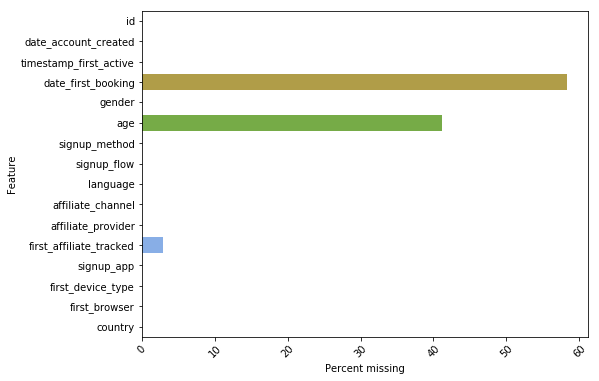

In [10]:
null_vals = mydf_train.isnull().sum()/len(mydf_train)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Percent missing",y ="Feature",data = null_vals,orient = "h")

In [11]:
# Drop column date_first_booking as it has more than 80% of null values
mydf_train2 = mydf_train.drop("date_first_booking",axis = 1)
print(mydf_train2.shape)
mydf_train2.head(2)

(213451, 15)


,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country
0,gxn3p5htnn,2010-06-28,20090319043255,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF


In [12]:
#Sorting values by date_account_created
mydf_sorted_train2=mydf_train2.sort_values(by='date_account_created')
mydf_sorted_train2.head(10)

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country
5,osr2jwljor,2010-01-01,20100101215619,-unknown-,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,20100102012558,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
7,0d01nltbrs,2010-01-03,20100103191905,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US
9,6uh8zyj2gn,2010-01-04,20100104023758,-unknown-,46.0,basic,0,en,other,craigslist,omg,Web,Mac Desktop,Firefox,US
8,a1vcnhxeij,2010-01-04,20100104004211,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
10,yuuqmid2rp,2010-01-04,20100104194251,FEMALE,36.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Firefox,US
13,dy3rgx56cu,2010-01-05,20100105083259,FEMALE,37.0,basic,0,en,other,craigslist,linked,Web,Mac Desktop,Firefox,NDF
11,om1ss59ys8,2010-01-05,20100105051812,FEMALE,47.0,basic,0,en,other,craigslist,untracked,Web,iPhone,-unknown-,NDF
12,k6np330cm1,2010-01-05,20100105060859,-unknown-,NaN,basic,0,en,direct,direct,NaN,Web,Other/Unknown,-unknown-,FR
16,2dwbwkx056,2010-01-07,20100107215125,-unknown-,NaN,basic,0,en,other,craigslist,NaN,Web,Other/Unknown,-unknown-,NDF


In [13]:
mydf_sorted_train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 5 to 213450
Data columns (total 15 columns):
id                         213451 non-null object
date_account_created       213451 non-null datetime64[ns]
timestamp_first_active     213451 non-null int64
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country                    213451 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(11)
memory usage: 26.1+ MB


In [14]:
# Converting timestamp to datetime format
mydf_sorted_train2['timestamp_first_active'] = pd.to_datetime((mydf_sorted_train2.timestamp_first_active), format='%Y%m%d%H%M%S')

In [15]:
# Split timestamp 
mydf_sorted_train2['weekday_first_active'] = mydf_sorted_train2.timestamp_first_active.dt.weekday_name
mydf_sorted_train2['day_first_active'] = mydf_sorted_train2.timestamp_first_active.dt.day
mydf_sorted_train2['month_first_active'] = mydf_sorted_train2.timestamp_first_active.dt.month
mydf_sorted_train2['year_first_active'] = mydf_sorted_train2.timestamp_first_active.dt.year
mydf_sorted_train2['hour_first_active'] = mydf_sorted_train2.timestamp_first_active.dt.hour
mydf_sorted_train2['minute_first_active'] = mydf_sorted_train2.timestamp_first_active.dt.minute
mydf_sorted_train2['second_first_active'] = mydf_sorted_train2.timestamp_first_active.dt.second

In [16]:
# Drop timestamp after splitting it
mydf_sorted_train2 = mydf_sorted_train2.drop("timestamp_first_active",axis = 1)
print(mydf_sorted_train2.shape)
mydf_sorted_train2.head(2)

(213451, 21)


,id,date_account_created,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,...,first_device_type,first_browser,country,weekday_first_active,day_first_active,month_first_active,year_first_active,hour_first_active,minute_first_active,second_first_active
5,osr2jwljor,2010-01-01,-unknown-,NaN,basic,0,en,other,other,omg,...,Mac Desktop,Chrome,US,Friday,1,1,2010,21,56,19
6,lsw9q7uk0j,2010-01-02,FEMALE,46.0,basic,0,en,other,craigslist,untracked,...,Mac Desktop,Safari,US,Saturday,2,1,2010,1,25,58


In [17]:
#Check for total number of missing values
no_of_missing_values=mydf_sorted_train2.isnull().sum().sum()
no_of_missing_values

94055

In [18]:
#Define functions
def split_dates(df,date_column):
    date_df = pd.DataFrame({"year": df[date_column].dt.year,
              "month": df[date_column].dt.month,
              "day": df[date_column].dt.day,
              "dayofyear": df[date_column].dt.dayofyear,
              "week": df[date_column].dt.week,
              "weekofyear": df[date_column].dt.weekofyear,
              "dayofweek": df[date_column].dt.dayofweek,
              "weekday": df[date_column].dt.weekday,
              "quarter": df[date_column].dt.quarter,
             })
    df = df.drop(date_column,axis = 1)
    df = pd.concat([df,date_df],axis = 1)
    return df

def str_to_cat(my_df):
    for p,q in my_df.items(): 
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df
def mydf_to_nums(my_df, content, label):
    if not is_numeric_dtype(content):
        my_df[label] = content.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for label,content in my_df.items(): 
        mydf_to_nums(my_df, content, label)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [19]:
#Split "date_account_created" using the split_dates method defined in the previous step
mydf_sorted_train3 = split_dates(mydf_sorted_train2,"date_account_created")
print(mydf_sorted_train3.shape)

(213451, 29)


In [20]:
print(mydf_sorted_train3.shape)

(213451, 29)


In [21]:
mydf_sorted_train3.iloc[:,1:] = str_to_cat(mydf_sorted_train3.iloc[:,1:]) # exclude id column
print(mydf_sorted_train3.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 5 to 213450
Data columns (total 29 columns):
id                         213451 non-null object
gender                     213451 non-null category
age                        125461 non-null float64
signup_method              213451 non-null category
signup_flow                213451 non-null int64
language                   213451 non-null category
affiliate_channel          213451 non-null category
affiliate_provider         213451 non-null category
first_affiliate_tracked    207386 non-null category
signup_app                 213451 non-null category
first_device_type          213451 non-null category
first_browser              213451 non-null category
country                    213451 non-null category
weekday_first_active       213451 non-null category
day_first_active           213451 non-null int64
month_first_active         213451 non-null int64
year_first_active          213451 non-null int64
hour_first_active   

In [22]:
mydf_sorted_train4 = str_to_cat(mydf_sorted_train3)
print(mydf_sorted_train4.shape)
mydf_sorted_train4.head(3)

(213451, 29)


,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,second_first_active,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter
5,osr2jwljor,-unknown-,NaN,basic,0,en,other,other,omg,Web,...,19,2010,1,1,1,53,53,4,4,1
6,lsw9q7uk0j,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,...,58,2010,1,2,2,53,53,5,5,1
7,0d01nltbrs,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,...,5,2010,1,3,3,53,53,6,6,1


In [23]:
mydf_sorted_train4.iloc[:,1:]

,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,...,second_first_active,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter
5,-unknown-,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,...,19,2010,1,1,1,53,53,4,4,1
6,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,...,58,2010,1,2,2,53,53,5,5,1
7,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,...,5,2010,1,3,3,53,53,6,6,1
9,-unknown-,46.0,basic,0,en,other,craigslist,omg,Web,Mac Desktop,...,58,2010,1,4,4,1,1,0,0,1
8,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,...,11,2010,1,4,4,1,1,0,0,1
10,FEMALE,36.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,...,51,2010,1,4,4,1,1,0,0,1
13,FEMALE,37.0,basic,0,en,other,craigslist,linked,Web,Mac Desktop,...,59,2010,1,5,5,1,1,1,1,1
11,FEMALE,47.0,basic,0,en,other,craigslist,untracked,Web,iPhone,...,12,2010,1,5,5,1,1,1,1,1
12,-unknown-,NaN,basic,0,en,direct,direct,NaN,Web,Other/Unknown,...,59,2010,1,5,5,1,1,1,1,1
16,-unknown-,NaN,basic,0,en,other,craigslist,NaN,Web,Other/Unknown,...,25,2010,1,7,7,1,1,3,3,1


In [24]:
mydf_sorted_train4,my_table = mydf_preprocessor(mydf_sorted_train4.iloc[:,1:],null_table = None)
print(mydf_sorted_train4.shape)
mydf_sorted_train4.head(3)

(213451, 28)


,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,...,second_first_active,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter
5,1,34.0,1,0,6,4,13,4,3,4,...,19,2010,1,1,1,53,53,4,4,1
6,2,46.0,1,0,6,4,3,7,3,4,...,58,2010,1,2,2,53,53,5,5,1
7,2,47.0,1,0,6,3,5,4,3,4,...,5,2010,1,3,3,53,53,6,6,1


In [25]:
my_table

{'age': 34.0}

In [26]:
#Checking missing values after imputation
no_of_missing_values=mydf_sorted_train4.isnull().sum().sum()
no_of_missing_values

0

In [27]:
my_table

{'age': 34.0}

In [28]:
'''Now, let's separate the X and Y variables (vertical split of the dataframe). 
Here the Y column is the variable we are trying to predict - destination of the country'''

Y = mydf_sorted_train4["country"]
X = mydf_sorted_train4.drop(["country"],axis = 1)

print(X.shape,Y.shape)

(213451, 27) (213451,)


In [29]:
#Split training data as training set and validation set

def mydf_train_splitter(my_df_train,num_rows):
    return my_df_train[:num_rows].copy(),my_df_train[num_rows:]

X_train,X_valid = mydf_train_splitter(X,153451)
Y_train,Y_valid = mydf_train_splitter(Y,153451)

print(X_train.shape,X_valid.shape,Y_train.shape,Y_valid.shape)

(153451, 27) (60000, 27) (153451,) (60000,)


In [31]:
#Function to create a model for DNN

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
seed = 1

# Function to create model
def create_model():
     # create model
    model = Sequential()
    model.add(Dense(35, input_dim=27, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(12, activation='relu'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [32]:
#Selecting 5 classifiers to test for better performance

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from keras.wrappers.scikit_learn import KerasClassifier

models = []

models.append(('KNN',KNeighborsClassifier(n_neighbors=20,weights='uniform')))
models.append(('Naive Bayes',GaussianNB()))
models.append(('DNN',KerasClassifier(build_fn=create_model, epochs=100, batch_size=100, verbose=False)))
models.append(('Random Forest',RandomForestClassifier(n_jobs = -1, n_estimators = 100,max_features = 0.5,random_state=1,
                               bootstrap = True)))
models.append(('XGBoost',XGBClassifier(max_depth=5, learning_rate=0.05, n_estimators=200,
                    objective='multi:softprob', subsample=0.5, colsample_bytree=0.5, seed=0)))


In [33]:
#Fitting the model with all the 5 classifiers defined above

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

names = []
accuracy_scores = []
for name, model in models:
    model.fit(X_train,Y_train)
    Y_pred = model.predict(X_valid)
    accuracy_scores.append(accuracy_score(Y_valid,Y_pred))
    names.append(name)
    
DF = pd.DataFrame({'Name': names, 'Accuracy_Score': accuracy_scores})
print(DF)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
            Name  Accuracy_Score
0            KNN        0.587667
1    Naive Bayes        0.612383
2            DNN        0.616000
3  Random Forest        0.648283
4        XGBoost        0.655967


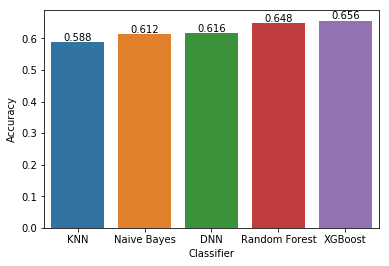

In [34]:
# Plot Classifier accuracies

clf = sns.barplot(x = 'Name', y = 'Accuracy_Score', data = DF)
clf.set(xlabel='Classifier', ylabel='Accuracy')
for p in clf.patches:
    height = p.get_height()
    clf.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.3f}'.format(height), ha="center") 
plt.show()

#### As we can see, XGBoost performed better than all other classifiers. So, we fit our model using XGBoost

In [35]:
from xgboost import XGBClassifier
model_xgb = XGBClassifier(max_depth=5, learning_rate=0.05, n_estimators=200,
                    objective='multi:softprob', subsample=0.5, colsample_bytree=0.5, seed=0)                  
model_xgb.fit(X_train,Y_train)
Y_pred_xgb = model_xgb.predict(X_valid)
accuracy_score(Y_valid,Y_pred_xgb)

0.6559666666666667

#### Plot Feature Selection

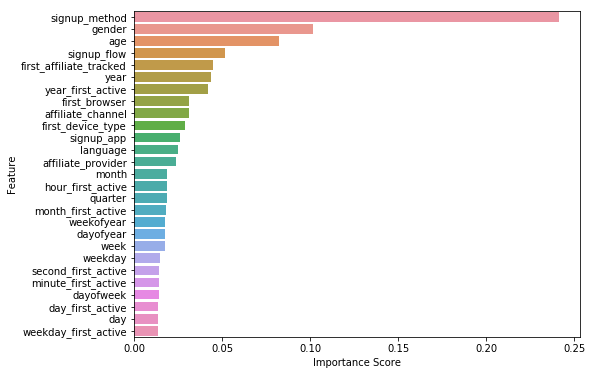

In [36]:
feat_imps = pd.DataFrame(model_xgb.feature_importances_, index = X_train.columns,
                                    columns=['Importance score']).sort_values('Importance score',ascending=False)
feat_imps = feat_imps.reset_index()
feat_imps.columns = ["Feature","Importance Score"]
plt.figure(figsize = (8,6))
sns.barplot(x = "Importance Score",y = "Feature",data = feat_imps,orient = "h")

#### As it seems all features are important, we retain all features

## Evaluating Test Set

In [37]:
'''Read in test data'''
my_test = pd.read_csv(f'{my_path}/test_users.csv',parse_dates = ["date_account_created"])

### Follow the same steps of preprocessing for test set

In [38]:
my_test1 = my_test.drop("date_first_booking",axis = 1)

In [39]:
my_test1['timestamp_first_active'] = pd.to_datetime((my_test1.timestamp_first_active), format='%Y%m%d%H%M%S')

In [40]:
my_test1['weekday_first_active'] = str(my_test1.timestamp_first_active.dt.weekday_name)
my_test1['day_first_active'] = str(my_test1.timestamp_first_active.dt.day)
my_test1['month_first_active'] = str(my_test1.timestamp_first_active.dt.month)
my_test1['year_first_active'] = str(my_test1.timestamp_first_active.dt.year)
my_test1['hour_first_active'] = str(my_test1.timestamp_first_active.dt.hour)
my_test1['minute_first_active'] = str(my_test1.timestamp_first_active.dt.minute)
my_test1['second_first_active'] = str(my_test1.timestamp_first_active.dt.second)

In [41]:
my_test1.iloc[:,2:] = str_to_cat((my_test1.iloc[:,2:]))

In [42]:
my_test2 = my_test1.drop("timestamp_first_active",axis = 1)

In [43]:
my_test3 = split_dates(my_test2,"date_account_created")

In [44]:
my_test3.head(3)

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,second_first_active,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter
0,5uwns89zht,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,...,0 6\n1 51\n2 48\n3 ...,2014,7,1,182,27,27,1,1,3
1,jtl0dijy2j,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,...,0 6\n1 51\n2 48\n3 ...,2014,7,1,182,27,27,1,1,3
2,xx0ulgorjt,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,...,0 6\n1 51\n2 48\n3 ...,2014,7,1,182,27,27,1,1,3


In [45]:
my_test3.iloc[:,1:],my_table1 = mydf_preprocessor(my_test3.iloc[:,1:],null_table = my_table)
print(my_test3.shape)
my_test3.head(3)
print(my_table1)

(62096, 28)
{'age': 34.0}


In [46]:
my_test3.iloc[:,1:].columns

Index(['gender', 'age', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'first_browser',
       'weekday_first_active', 'day_first_active', 'month_first_active',
       'year_first_active', 'hour_first_active', 'minute_first_active',
       'second_first_active', 'year', 'month', 'day', 'dayofyear', 'week',
       'weekofyear', 'dayofweek', 'weekday', 'quarter'],
      dtype='object')

In [47]:
'''Predictions for the test set'''
y_tst_pred = model_xgb.predict(my_test3.iloc[:,1:])
print(type(y_tst_pred))

<class 'numpy.ndarray'>


In [48]:
my_test3['country']= y_tst_pred

In [49]:
col_names = list(my_test3)
for col in col_names:
    my_test3[col] = my_test3[col].astype('category',copy=False)

In [51]:
#Replacing numeric values for country with initial string values
country_lookup = dict(zip(mydf_train['country'].astype('category').cat.codes + 1,
                          mydf_train['country']))

In [52]:
my_test3['country'] = my_test3['country'].replace(country_lookup)

In [53]:
my_test3.head(2)

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter,country
0,5uwns89zht,2,35.0,2,0,7,2,5,7,2,...,2014,7,1,182,27,27,1,1,3,NDF
1,jtl0dijy2j,1,34.0,1,0,7,2,5,7,2,...,2014,7,1,182,27,27,1,1,3,NDF


#### Extracting submission results to csv file

In [55]:
my_test3[['id','country']].to_csv("C:\\Users\\Soumya\\Documents\\NEU\\INFO6105\\airbnb-recruiting-new-user-bookings\\submission1.csv",index=False,header=True)